# Connect to Azure ML workspace

In [1]:
from azureml.core import Workspace

workspace_name = 'sd-ml'
subscription_id = 'c374c749-c070-4b3b-9fb4-40a657b1d4a5' # subscription id of ADLS account
resource_group = 'rs-sd-learn-sth-new' # resource group of ADLS account

workspace = Workspace.get(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group
)

print ("workspace to be used: " + workspace.name)


workspace to be used: sd-ml


# Get or set up datastore

In [2]:
from azureml.core import Datastore

datastore_name = 'learnsthnew_datastore'
filesystem = 'learnsthnew'

subscription_id = 'c374c749-c070-4b3b-9fb4-40a657b1d4a5' # subscription id of ADLS account
resource_group = 'rs-sd-learn-sth-new' # resource group of ADLS account

account_name = 'sdsalearnsthnew' # ADLS Gen2 account name
tenant_id = '680b5d20-b41e-46f8-a077-f482d0c64dbb' # tenant id of service principal
client_id = '6df9c689-4854-45ec-a9c2-55194c54c511' # client id of service principal
client_secret = 'Is5A5Jctw1~Ge-hi4EOS_RmRahG5_s43F4' # the secret of service principal

try:
    datastore = Datastore.get(
        workspace = workspace,
        datastore_name = datastore_name
    )
except Exception as exc:
    datastore = Datastore.register_azure_data_lake_gen2(
        workspace = workspace,
        subscription_id = subscription_id,
        resource_group = resource_group,
        datastore_name = datastore_name,
        account_name = account_name, # ADLS Gen2 account name
        filesystem = filesystem, # ADLS Gen2 filesystem
        tenant_id = tenant_id, # tenant id of service principal
        client_id = client_id, # client id of service principal
        client_secret = client_secret # the secret of service principal
    )

print ("datastore to be used: " + datastore.name)


datastore to be used: learnsthnew_datastore


# Get or set up dataset

In [3]:
from azureml.core import Dataset

datastore_name = 'learnsthnew_datastore'
dataset_name = 'playlist_statistics'
dataset_description = 'radio song playlist statistics'

try:
    dataset = Dataset.get_by_name(
        workspace = workspace, 
        name = dataset_name
    )
except Exception as exc:
    datastore_paths = [(datastore, '/analytics/playlist_statistics.parquet/*.parquet')]
    dataset = Dataset.Tabular.from_parquet_files(path=datastore_paths, validate=False)
    dataset = dataset.register(
        workspace=workspace,
        name = dataset_name,
        description = dataset_description
    )

print ("dataset to be used: " + dataset.name)

dataset to be used: playlist_statistics


# Read data and convert dataset to pandas dataframe

In [4]:
df = dataset.to_pandas_dataframe()

# Check sample 5 rows of current dataset

In [5]:
df.head()

,radio_name,month_name,artist_and_title,played
0,RMFFM,January,#razemrobimydobro - Razem,0
1,RMFFM,January,2+1 - Chodź Pomaluj Mój Świat,0
2,RMFFM,January,Abba - Mamma Mia,1
3,RMFFM,January,Abc - The Look Of Love,0
4,RMFFM,January,Ac/dc - Thunderstruck,0


# Exploratory data analysis

* Exploratory data analysis - initial checking, investigating and getting the knowledge about the dataset
* in that case we see that the dataset is really skewed in terms of songs that were played and that were not played, that metters, **remember to choose the best algorithem for your data**

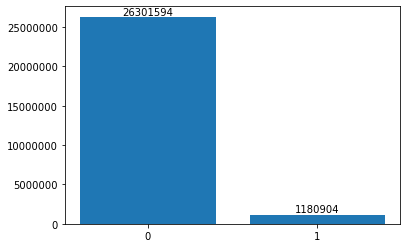

In [6]:
import matplotlib.pyplot as plt

# create dataset for chart
df_played_song_statistics = df[['played']].groupby(['played']).size().to_frame('cnt').reset_index()

x = df_played_song_statistics['played'].astype(str)
y = df_played_song_statistics['cnt']

# create chart
plt.bar(x, y)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

for index, value in enumerate(y):
    plt.text(index,value, str(value), ha='center', va='bottom')

plt.show()


# Encode the categorical text attributes to numeric values

Some ML algorithemes doesn't work that great or doesn't work at all with the text attributes and therefore we should perform some feature preperation. 
There is many options avaliablle in that case we will use Label Encoding, but one of the other extreamly popular way would be OneHotEncoder.
OneHotEncoder would create a new column for each distint value of the attribute with a boolean information if the given example is assigned to. 
Please note that in the case of song title that would dramatically increase the size of the dataframe.

We will perform a label encoder which will convert all text values to the numerical values so the same text value will get the same numeric value.

Example:
* January - 0
* February - 1
* ...
* November - 10
* December - 11

That will be done automatically with usage of sklearn library.


In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['radio_name_enc'] = labelencoder.fit_transform(df['radio_name'])
df['month_name_enc'] = labelencoder.fit_transform(df['month_name'])
df['artist_and_title_enc'] = labelencoder.fit_transform(df['artist_and_title'])

# Check sample 5 rows of current dataset

In [8]:
df.head()

,radio_name,month_name,artist_and_title,played,radio_name_enc,month_name_enc,artist_and_title_enc
0,RMFFM,January,#razemrobimydobro - Razem,0,0,4,0
1,RMFFM,January,2+1 - Chodź Pomaluj Mój Świat,0,0,4,11
2,RMFFM,January,Abba - Mamma Mia,1,0,4,40
3,RMFFM,January,Abc - The Look Of Love,0,0,4,45
4,RMFFM,January,Ac/dc - Thunderstruck,0,0,4,49


# Split the dataset into features and labels

Features - attributes that will be used to predict the target value, please note that here we are using the encoded attributes and not the original ones

Label - the label of each row, also the value that will be predicted

In [9]:
# Separate features and labels
features = ["radio_name_enc", "month_name_enc", "artist_and_title_enc"]
label = 'played'
X, y = df[features].values, df[label].values


# Split dataset into train and test subsets

In [10]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 19237748
Test cases: 8244750


# Create prediction model using LogisticRegression and validate the model

* **Accuracy classification score** - In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
* **Other metrics** - Precision, Recall, F1-Score, Support, etc, please read more in that area
* **Confusion matrix** - Compute confusion matrix to evaluate the accuracy of a classification.
![alt text](img/confusion_matrix.png)


In [11]:
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model_a = LogisticRegression(C=1/reg, solver="liblinear")
model_a.fit(X_train, y_train)
predictions_a = model_a.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, predictions_a))
print(confusion_matrix(y_test, predictions_a))


Accuracy:  0.9569386579338367
[[7889720       0]
 [ 355030       0]]


# Create prediction model using DecissionTreeClassifier and validate the model

In [12]:
# Train the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create Decision Tree classifer object
model_b = DecisionTreeClassifier()
model_b.fit(X_train,y_train)
predictions_b = model_b.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, predictions_b))
print(confusion_matrix(y_test, predictions_b))

Accuracy:  0.9571007004457383
[[7884085    5635]
 [ 348059    6971]]


# Use the model to check (predict) if given song will be played
* use christmass song - Wham! - Last Christmas
* check for two different months - July and December

In [13]:
radio_name = 'RMFFM'
artist_and_title = 'Wham! - Last Christmas'
month_a = 'December'
month_b = 'June'

radio_enc = df.loc[((df['radio_name'] == radio_name))][["radio_name_enc"]].drop_duplicates( keep="first").values[0][0]
artist_title_enc = df.loc[((df['artist_and_title'] == artist_and_title))][["artist_and_title_enc"]].drop_duplicates( keep="first").values[0][0]
month_a_enc = df.loc[((df['month_name'] == month_a))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]
month_b_enc = df.loc[((df['month_name'] == month_b))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]

model_a_month_a = model_a.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_a_month_b = model_a.predict([[radio_enc,month_b_enc,artist_title_enc]])
model_b_month_a = model_b.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_b_month_b = model_b.predict([[radio_enc,month_b_enc,artist_title_enc]])

print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_a_month_a[0])}" )
print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_a_month_b[0])}" )
print (f"Predict results using model 'b' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_b_month_a[0])}" )
print (f"Predict results using model 'b' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_b_month_b[0])}" )

Predict results using model 'a' for radio: RMFFM, month: Dec, artist and title: Wham! - Last Christmas, results 0
Predict results using model 'a' for radio: RMFFM, month: Jun, artist and title: Wham! - Last Christmas, results 0
Predict results using model 'b' for radio: RMFFM, month: Dec, artist and title: Wham! - Last Christmas, results 1
Predict results using model 'b' for radio: RMFFM, month: Jun, artist and title: Wham! - Last Christmas, results 0


# Use the model to check (predict) if given song will be played
* use christmass song - Rotary - Na Jednej Z Dzikich Plaż
* check for two different months - July and December

In [14]:
radio_name = 'RMFFM'
artist_and_title = 'Rotary - Na Jednej Z Dzikich Plaż'
month_a = 'December'
month_b = 'June'

radio_enc = df.loc[((df['radio_name'] == radio_name))][["radio_name_enc"]].drop_duplicates( keep="first").values[0][0]
artist_title_enc = df.loc[((df['artist_and_title'] == artist_and_title))][["artist_and_title_enc"]].drop_duplicates( keep="first").values[0][0]
month_a_enc = df.loc[((df['month_name'] == month_a))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]
month_b_enc = df.loc[((df['month_name'] == month_b))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]

model_a_month_a = model_a.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_a_month_b = model_a.predict([[radio_enc,month_b_enc,artist_title_enc]])
model_b_month_a = model_b.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_b_month_b = model_b.predict([[radio_enc,month_b_enc,artist_title_enc]])

print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_a_month_a[0])}" )
print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_a_month_b[0])}" )
print (f"Predict results using model 'b' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_b_month_a[0])}" )
print (f"Predict results using model 'b' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_b_month_b[0])}" )

Predict results using model 'a' for radio: RMFFM, month: Dec, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 0
Predict results using model 'a' for radio: RMFFM, month: Jun, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 0
Predict results using model 'b' for radio: RMFFM, month: Dec, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 0
Predict results using model 'b' for radio: RMFFM, month: Jun, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 1


# Export model to file

In [15]:
import joblib

# Save the model as a pickle file
filename = './models/song_model.pkl'
joblib.dump(model_b, filename)

['./models/song_model.pkl']

# Import model from file

In [16]:
import joblib

# Load the model from the file
filename = './models/song_model.pkl'
model = joblib.load(filename)

# Use the model imported from file for new prediction

In [20]:
radio_name = 'RMFFM'
artist_and_title = 'Wham! - Last Christmas'
month_a = 'December'
month_b = 'June'

radio_enc = df.loc[((df['radio_name'] == radio_name))][["radio_name_enc"]].drop_duplicates( keep="first").values[0][0]
artist_title_enc = df.loc[((df['artist_and_title'] == artist_and_title))][["artist_and_title_enc"]].drop_duplicates( keep="first").values[0][0]
month_a_enc = df.loc[((df['month_name'] == month_a))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]
month_b_enc = df.loc[((df['month_name'] == month_b))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]

model_month_a = model.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_month_b = model.predict([[radio_enc,month_b_enc,artist_title_enc]])

print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_month_a[0])}" )
print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_month_b[0])}" )

Predict results using model 'a' for radio: RMFFM, month: Dec, artist and title: Wham! - Last Christmas, results 1
Predict results using model 'a' for radio: RMFFM, month: Jun, artist and title: Wham! - Last Christmas, results 0


In [19]:
radio_name = 'RMFFM'
artist_and_title = 'Rotary - Na Jednej Z Dzikich Plaż'
month_a = 'December'
month_b = 'June'

radio_enc = df.loc[((df['radio_name'] == radio_name))][["radio_name_enc"]].drop_duplicates( keep="first").values[0][0]
artist_title_enc = df.loc[((df['artist_and_title'] == artist_and_title))][["artist_and_title_enc"]].drop_duplicates( keep="first").values[0][0]
month_a_enc = df.loc[((df['month_name'] == month_a))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]
month_b_enc = df.loc[((df['month_name'] == month_b))][["month_name_enc"]].drop_duplicates( keep="first").values[0][0]

model_month_a = model.predict([[radio_enc,month_a_enc,artist_title_enc]])
model_month_b = model.predict([[radio_enc,month_b_enc,artist_title_enc]])

print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_a[0:3]}, artist and title: {artist_and_title}, results {str(model_month_a[0])}" )
print (f"Predict results using model 'a' for radio: {radio_name}, month: {month_b[0:3]}, artist and title: {artist_and_title}, results {str(model_month_b[0])}" )

Predict results using model 'a' for radio: RMFFM, month: Dec, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 0
Predict results using model 'a' for radio: RMFFM, month: Jun, artist and title: Rotary - Na Jednej Z Dzikich Plaż, results 1
